In [529]:
#The HR Analytics dateset from kaggle competitions 
#Import of  necessary libraries, Modules and classifiers
import numpy as np  #fundamental package for scientific computing with Python
import pandas as pd #package providing fast, flexible, and expressive data structures
import matplotlib.pyplot as plt #for plotting different kinds of diagrams
#commands in cells below the cell that outputs a plot will not affect the plot inline command 
#(commentation on the same line causes an error):
%matplotlib inline 
import seaborn as sns #visualization library based on matplotlib, for statistical data visualization
from IPython.display import display_html

hr_data=pd.read_csv('.\HR_comma_sep.csv',header=0) #read the data from a csv-file; ensure that the  v
#alues are separated by commas otherwise you need to specify the delimiter explicitly within the load-statement

hr_data_copy=hr_data.copy()  #create a deep copy of the data set for demonstrating how to handle missing values (mv)

hr_data.head() #show the first five entries; attribute in brackets will give the # of printed lines 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [530]:
###We define small helper functions (Code from E-M-A-D; https://www.kaggle.com/etakla)
#A function for annotating the bars with its total and relative number. 
def annotate_bars(bar_plt, bar_plt_var, by=None, x_offset=0, y_offset=0, txt_color="white", fnt_size=12, fnt_weight='bold'):
    if by is None:
        for p in bar_plt.patches:
            bar_plt.annotate(str( int(p.get_height()) ) + "\n" + str(round( (100.0* p.get_height()) /bar_plt_var.count(), 1) )
                             + "%", 
                             (p.get_x() + x_offset, p.get_height()-y_offset),
                             color=txt_color, fontsize=fnt_size, fontweight=fnt_weight)
    else:
        grouped = bar_plt_var.groupby(by)
        for p in bar_plt.patches:            
            #This part is tricky. The problem is that not each x-tick gets drawn in order, 
            #i.e. yes/no of the first group then yes/no of the second group located on the 
            #next tick, but rather all the yes on all the x-ticks get drawn first then all 
            #the nos next. So we need to know we are using a patch that belongs to which 
            #tick (the x-tick) ultimately refers to one of the groups. So, we get the x absolute 
            #coordinate, round it to know this patch is closest to which tick (Assuming that it 
            #will always belong to its closest tick), then get the group count of that tick and 
            #use it as a total to compute the percentage.
            total = grouped.get_group(bar_plot.get_xticks()[int(round(p.get_x()))]).count()
            bar_plt.annotate(str( int(p.get_height()) ) + "\n" + str(round( (100.0* 
                                                                             p.get_height()) /total, 1) )+ "%", 
                             (p.get_x() + x_offset, p.get_height()-y_offset),
                             color=txt_color, fontsize=fnt_size, fontweight=fnt_weight)
            
#A function that returns the order of a group_by object according to the average of certain parameter param.
def get_ordered_group_index(df, group_by, param, ascending=False):
    return df.groupby(group_by)[param].mean().sort_values(ascending=ascending).index

#helper function that returns the order of a group_by object according to the average of certain parameter param.
def group_by_2_level_perc(df, level1, level2, level1_index_order = None, level2_index_order = None):
    #http://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
    df_by_lvl1_lvl2 = df.groupby([level1, level2]).agg({level1: 'count'})
    df_by_lvl1_lvl2_perc = df_by_lvl1_lvl2.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    #Reorder them in logical ascending order, but first make sure it is not an empty input
    if level1_index_order:
        df_by_lvl1_lvl2_perc = df_by_lvl1_lvl2_perc.reindex_axis(level1_index_order, axis=0, level=0)
    #If a second level order is passed, apply it, else use the default
    if level2_index_order:
        df_by_lvl1_lvl2_perc = df_by_lvl1_lvl2_perc.reindex_axis(level2_index_order, axis=0, level=1)
    return df_by_lvl1_lvl2_perc

#A function that adds some styling to the graphs, like custom ticks for axes, axes labels and a grid
def customise_2lvl_perc_area_graph(p, legend_lst, xtick_label = "", x_label="", y_label=""):
    #If custom ticks are passed, spread them on the axe and write the tick values
    if xtick_label:
        p.set_xticks(range(0,len(xtick_label)))
        p.set_xticklabels(xtick_label)
    #Create y ticks for grid. It will always be a percentage, so it is not customisable
    p.set_yticks(range(0,110,10)) 
    p.set_yticklabels(['{:3.0f}%'.format(x) for x in range(0,110,10)])
    p.set_yticks(range(0,110,5), minor=True) 

    #Draw grid and set y limit to be only 100 (By default it had an empty area at the top of the graph)
    p.xaxis.grid('on', which='major', zorder=1, color='gray', linestyle='dashed')
    p.yaxis.grid('on', which='major', zorder=1, color='gray', alpha=0.2)
    p.yaxis.grid('on', which='minor', zorder=1, color='gray', linestyle='dashed', alpha=0.2)
    p.set(ylim=(0,100))

    #Customise legend
    p.legend(labels=legend_lst, frameon=True).get_frame().set_alpha(0.2)

    #Put the axes labels
    if x_label:
        p.set_xlabel(x_label)
    if y_label:
        p.set_ylabel(y_label);

In [531]:
hr_data.info() #attribut specifications

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [532]:
hr_data.describe()  # show some statistics about the attributes of the data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Skew is: -0.476360341284


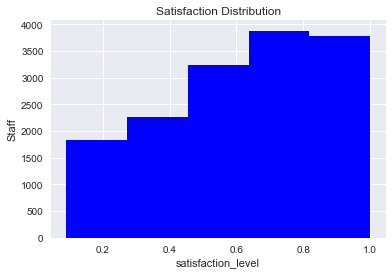

In [533]:
#To observe the distribution of satisfaction level among the employees we generate metrics 
#of skewness and plot the histogram of the satisfaction level.
print ("Skew is:", hr_data.satisfaction_level.skew()) #*.skew() shows tendency (0=no skewness, (-)=left skewed)

plt.hist(hr_data.satisfaction_level, color='blue',bins=5) #plot the histogram
#plt.hist needs argument "data" in form of a 1d numpy array
#we adress columns as numpy arrays by just adding their name to the data frame (e.g. df.variable_name).
#we choose the parameter color to be blue --> blue histogram and bins=5 to fit the data to 5 pillars.

plt.xlabel('satisfaction_level') #naming the x-axis
plt.ylabel('Staff') #labeling the y-axis
plt.title('Satisfaction Distribution') 
 
plt.show() #display the plot

In [534]:
if(not hr_data.isnull().values.any()):  #Checking for NaN-values  
    #If the iterable is empty, it returns False, True if any element of the iterable is true.  
    print('QC (Y): Dataset does not contain missing values')
else:
    print('QC (N): Dataset contains missing values')

QC (Y): Dataset does not contain missing values


In [535]:
#for showing how to handle missing values(mv), we randomly create some NaN-values inside the dataset 
import random
ix = [(row, col) for row in range(hr_data_copy.shape[0]) for col in range(hr_data_copy.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):   #for a 10% random sample in the sequenz ix
       hr_data_copy.iloc[row, col] = np.nan                  #entries replaced by NaN-values

In [536]:
hr_data_copy.head() #show the first five entries again with NaN-entries 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2.0,157.0,3.0,0.0,1.0,0.0,sales,low
1,0.80,NaN,5.0,262.0,6.0,0.0,NaN,0.0,sales,medium
2,0.11,0.88,7.0,272.0,4.0,0.0,1.0,0.0,sales,medium
3,0.72,0.87,5.0,223.0,NaN,0.0,1.0,0.0,sales,low
4,0.37,0.52,2.0,159.0,3.0,0.0,1.0,0.0,sales,low


In [537]:
hr_data_copy.describe() #just to show the mv-effect, now less entries, because of mv

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,13454.000000,13460.000000,13552.000000,13509.000000,13528.000000,13541.000000,13434.000000,13481.000000
mean,0.611872,0.716085,3.799439,200.989859,3.498891,0.144007,0.235894,0.021215
std,0.248637,0.171218,1.230587,49.928045,1.465706,0.351110,0.424572,0.144106
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.810000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [538]:
##there are 3 possibilities for handling missing values(mv): 
#1.to ignore  #2.to impute(fill)  3.to drop the datapoint with mv

In [539]:
##2.way - impute
#imputation strategies:
#  “mean” to replace missing values using the mean along the axis.
#  “median” to replace missing values using the median along the axis.
#  “most_frequent” to replace missing using the most frequent value along the axis.
hr_no_missing_f=hr_data_copy.fillna(hr_data_copy.iloc[:10].median()) 
hr_no_missing_f.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.589533,0.709305,3.915261,203.226015,3.548037,0.130009,0.315621,0.019068
std,0.244537,0.163430,1.222246,47.859131,1.399930,0.336324,0.464778,0.136768
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.395000,0.570000,3.000000,159.000000,3.000000,0.000000,0.000000,0.000000
50%,0.600000,0.680000,4.000000,211.000000,3.000000,0.000000,0.000000,0.000000
75%,0.800000,0.850000,5.000000,241.000000,4.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [540]:
#3.way - drop mv's
hr_no_missing_d = hr_data_copy.dropna()
hr_no_missing_d.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2.0,157.0,3.0,0.0,1.0,0.0,sales,low
2,0.11,0.88,7.0,272.0,4.0,0.0,1.0,0.0,sales,medium
4,0.37,0.52,2.0,159.0,3.0,0.0,1.0,0.0,sales,low
5,0.41,0.50,2.0,153.0,3.0,0.0,1.0,0.0,sales,low
13,0.41,0.55,2.0,148.0,3.0,0.0,1.0,0.0,sales,low


In [541]:
hr_no_missing_d.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,5274.000000,5274.000000,5274.000000,5274.000000,5274.000000,5274.000000,5274.000000,5274.000000
mean,0.612027,0.718129,3.809632,201.088737,3.514221,0.141259,0.230944,0.020478
std,0.246113,0.172167,1.230258,50.090823,1.487251,0.348322,0.421477,0.141641
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.810000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [542]:
hr_data.info() #attribut specifications, shows the datatype-information about the attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [543]:
print('Departments: ', ', '.join(hr_data['sales'].unique())) #show and join the unique entries in sales
#with the more precise description "departments"
print('Salary levels: ', ', '.join(hr_data['salary'].unique())) #show and join the unique entries in 
#salery with a descriptive level 

Departments:  sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RandD
Salary levels:  low, medium, high


In [544]:
hr_data.rename(columns={'sales':'department'}, inplace=True) #rename Column, note: you do need to 
#specify the existing label first followed by the new label to rename it to afterward 
hr_data_new = pd.get_dummies(hr_data, ['department', 'salary'] ,drop_first = True) #Whether to get k-1 
#dummies variables out of k categorical by removing the first level. New in Pandas version 0.18.0.
hr_data_new.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [545]:
'''Observe that "IT" and "high" are the baseline levels for the assigned department and salary level, 
respectively. Also note that we saved the data with dummy variables as another dataframe in case we need to 
access the string values, such as for a cross-tabulation table.'''

hr_data_new.describe() #Generates descriptive statistics that summarize the central tendency, 
#dispersion and shape of a dataset’s distribution. 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.487766,0.429762
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.499867,0.495059
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


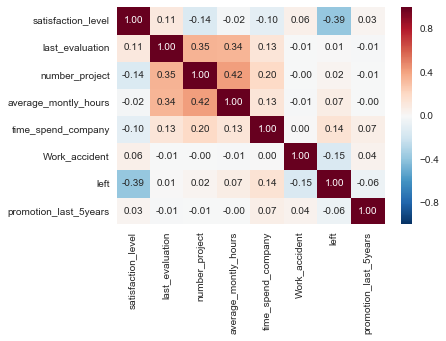

In [546]:
# Correlation matrix is used to do some basic visualizations and show any relationships in the data.
sns.heatmap(hr_data.corr(), annot=True,fmt='.2f');  #compute pairwise correlation of columns, 
#excluding NA/null values; annot=True presents heatmap with values, the format-configuration 
#makes it better to read (2 decimal places), <;> is hiding the processing steps

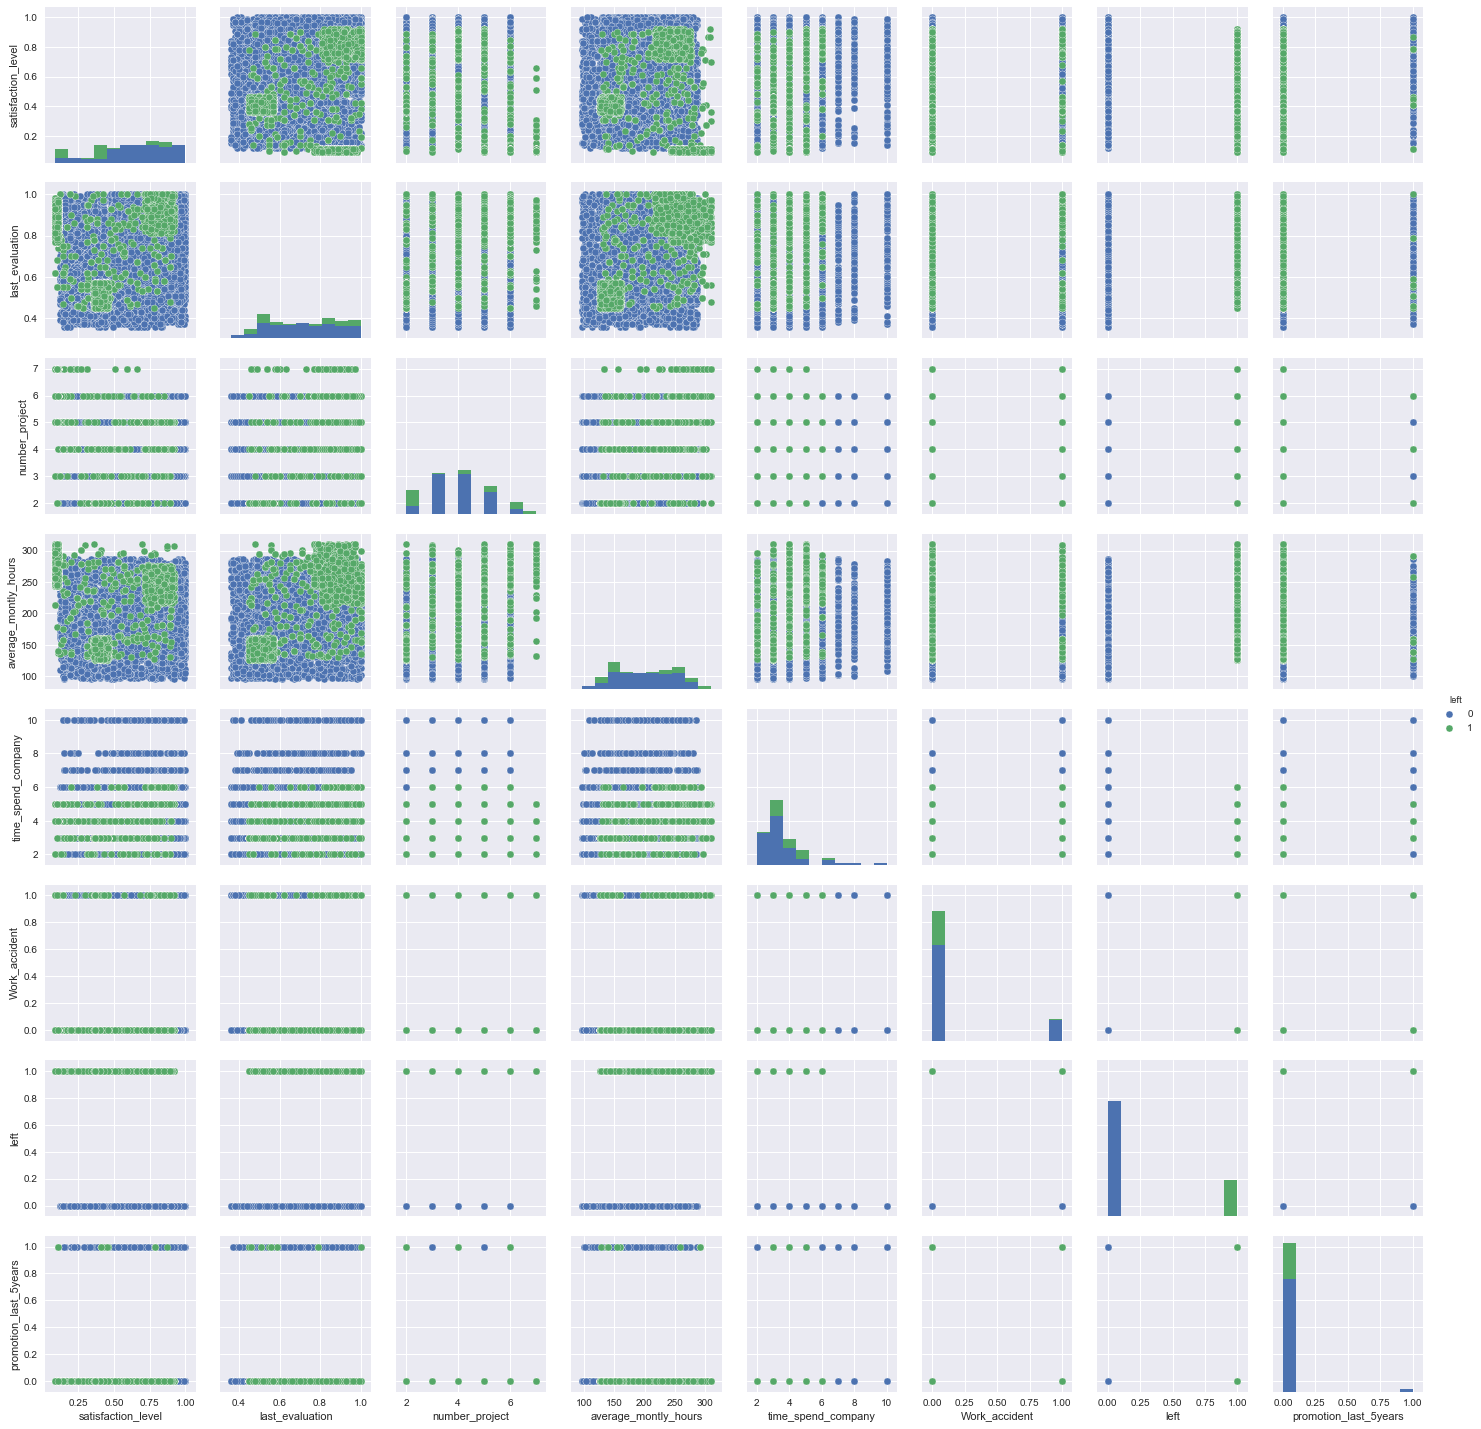

In [547]:
plt.figure(figsize=(10, 10)) #figure module, which contains all the plot elements

sns.pairplot(hr_data,  hue="left"); #distinguish the left feature

In [548]:
#Univariate Analysis
hr_by_left = hr_data.groupby('left')  #determine the groups on each value of the object’s index
employees_left = hr_by_left.get_group(1) #determine and store the group that left
employees_stayed = hr_by_left.get_group(0) #determine and store the group that stayed

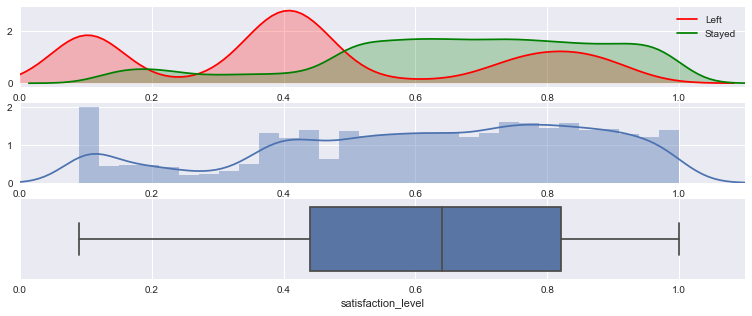

In [549]:
#distribution of Satisfaction Level
fig, axs = plt.subplots(nrows= 3, figsize=(13, 5))

sns.kdeplot(employees_left.satisfaction_level, ax=axs[0], shade=True, color="r")
kde_plot = sns.kdeplot(employees_stayed.satisfaction_level, ax=axs[0], shade=True, color="g")
kde_plot.legend(labels=['Left', 'Stayed'])

hist_plot = sns.distplot(hr_data.satisfaction_level, ax=axs[1])
box_plot = sns.boxplot(hr_data.satisfaction_level, ax=axs[2])

kde_plot.set(xlim=(0,1.1))
hist_plot.set(xlim=(0,1.1))
box_plot.set(xlim=(0,1.1));

In [550]:
#proportion of leaving and staying in the different departments: 
dept_table = pd.crosstab(hr_data['department'], hr_data['left'],normalize='index')
#We created a cross tabulation of columns left and department, the normalize parameter is
#dividing all values by the sum of values.
#parameter list for pandas.crosstab can be found in pandas documentation:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
dept_table.index.names = ['Department'] #naming of the index column
dept_table #print the cross tab

left,0,1
Department,,
IT,0.777506,0.222494
RandD,0.846252,0.153748
accounting,0.734029,0.265971
hr,0.709066,0.290934
management,0.855556,0.144444
marketing,0.763403,0.236597
product_mng,0.780488,0.219512
sales,0.755072,0.244928
support,0.751009,0.248991


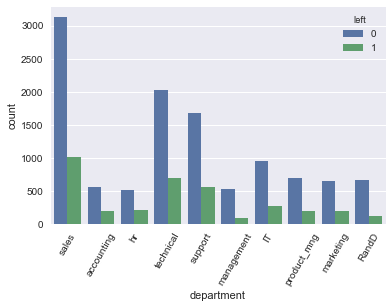

In [551]:
g=sns.countplot(x='department', hue='left', data=hr_data) #Show the number of observations 
#in each categorical bin of 'department' using bars.
for item in g.get_xticklabels():  #for every entry in x rotate the x-axis for better reading 
    item.set_rotation(60)         # No'in brackets = degrees in positive direction

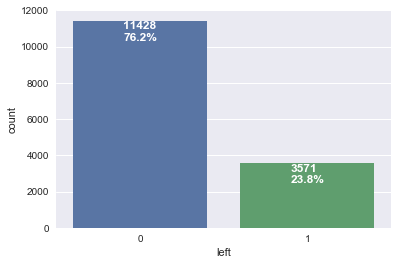

In [552]:
#Employees who Left their Jobs in sum
employees_left_plt = sns.countplot(hr_data.left);

for p in employees_left_plt.patches:
    employees_left_plt.annotate(str( int(p.get_height()) ) + "\n" + str(round( (100.0* p.get_height()) /hr_data.left.count(), 1) )+ "%", 
                                (p.get_x() + 0.3, p.get_height()-1100),
                                color='white', fontsize=12, fontweight='bold')

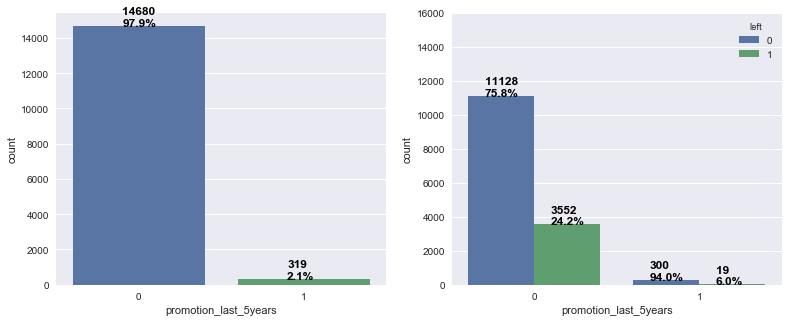

In [553]:
#Promotion within the Past 5 Years
fig, axs = plt.subplots(ncols= 2, figsize=(13, 5))

promoted_5years_plt = sns.countplot(hr_data.promotion_last_5years, ax=axs[0]);
annotate_bars(bar_plt=promoted_5years_plt, bar_plt_var=hr_data.promotion_last_5years, x_offset=0.3, txt_color="black")
    
bar_plot = sns.countplot(x=hr_data.promotion_last_5years, hue=hr_data.left, ax=axs[1])
annotate_bars(bar_plt=bar_plot, by=hr_data.promotion_last_5years, bar_plt_var=hr_data.promotion_last_5years, x_offset=0.1, txt_color="black")
bar_plot.set(ylim=(0,16000));

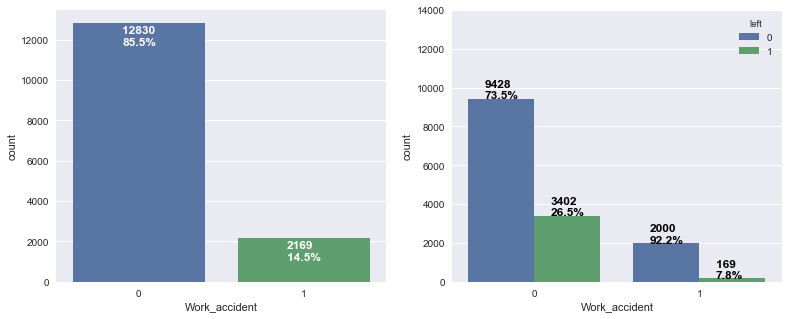

In [554]:
fig, axs = plt.subplots(ncols= 2, figsize=(13, 5)) #set the number and size of the diagram spaces

work_accidents_plt = sns.countplot(hr_data.Work_accident, ax=axs[0]);
annotate_bars(bar_plt=work_accidents_plt, bar_plt_var=hr_data.Work_accident, x_offset=0.3, y_offset=1100)
    
bar_plot = sns.countplot(x=hr_data.Work_accident, hue=hr_data.left, ax=axs[1])
annotate_bars(bar_plt=bar_plot, by=hr_data.Work_accident, bar_plt_var=hr_data.Work_accident, x_offset=0.1, txt_color="black")
bar_plot.set(ylim=(0,14000));

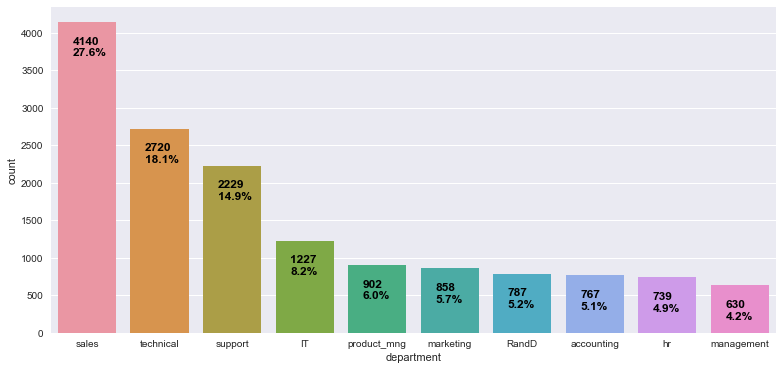

In [555]:
fig, axs = plt.subplots(figsize=(13, 6))

department_plt = sns.countplot(hr_data.department, order = hr_data.department.value_counts().index);

annotate_bars(bar_plt=department_plt, bar_plt_var=hr_data.department, x_offset=0.2, y_offset=450, txt_color="black")

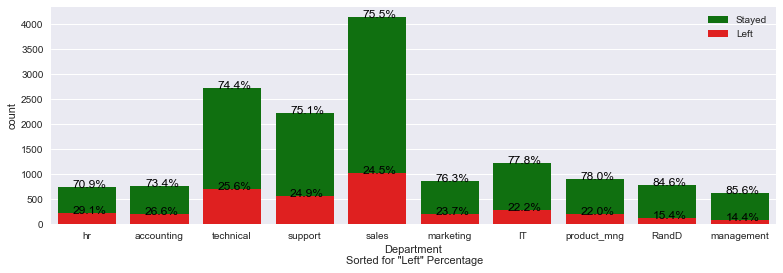

In [556]:
#Departments & Who Left; Is there a pattern?
fig, axs = plt.subplots(figsize=(13, 4))

#Order the bars descendingly according to the PERCENTAGE % of those who left in each department
total_employees_by_dept = hr_data.groupby(["department"]).satisfaction_level.count()
left_count_by_dept = hr_data[hr_data["left"] == 1].groupby(["department"]).satisfaction_level.count()
percentages_left_by_dept = (left_count_by_dept / total_employees_by_dept).sort_values(ascending=False)
axe_name_order = percentages_left_by_dept.index

department_plt = sns.countplot(hr_data.department, order = axe_name_order, color='g');
sns.countplot(employees_left.department, order = axe_name_order, color='r');

department_plt.legend(labels=['Stayed', 'Left'])
department_plt.set(xlabel='Department\n Sorted for "Left" Percentage')

#Annotate the percentages of those who stayed. It was more straightforward to loop for each 
#category (left, stayed) than doing all the work in one loop.
#The zip creates an output that is equal to the shortest parameter, so we do not need to adjust the 
#patches length, since the loop will stop after finishing the columns of those who stayed
for p, current_column in zip(department_plt.patches, axe_name_order):
    current_column_total = hr_data[hr_data['department'] == current_column].department.count()
    stayed_count = p.get_height() - employees_left[employees_left['department'] == current_column].department.count()
    department_plt.annotate(str(round( (100.0* stayed_count) /current_column_total, 1) )+ "%", 
                                (p.get_x() + 0.2, p.get_height()-10),
                                color='black', fontsize=12)
    
#In this loop, we want to use the patches located on the second half of patches list, which are the 
#bars for those who left.
for p, current_column in zip(department_plt.patches[int(len(department_plt.patches)/2):], axe_name_order):
    current_column_total = hr_data[hr_data['department'] == current_column].department.count()
    left_count = p.get_height()
    department_plt.annotate(str(round( (100.0* left_count) /current_column_total, 1) )+ "%", 
                                (p.get_x() + 0.2, p.get_height()-10),
                                color='black', fontsize=12)

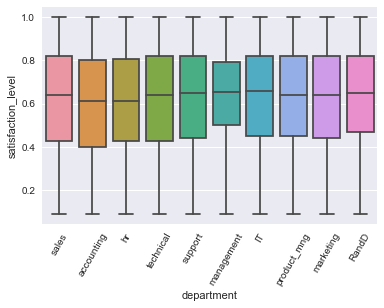

In [557]:
g=sns.boxplot(x='department', y='satisfaction_level', data=hr_data) #Draw a box plot to show 
#distributions (satisfaction level) with respect to categories (departments). A box plot (or
#box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates 
#comparisons between variables or across levels of a categorical variable. The box shows the 
#quartiles of the dataset while the whiskers extend to show the rest of the distribution, 
#except for points that are determined to be “outliers”. 
for item in g.get_xticklabels():  #rotate the x-axis for better reading 
    item.set_rotation(60) # No'in brackets = degrees in positive direction

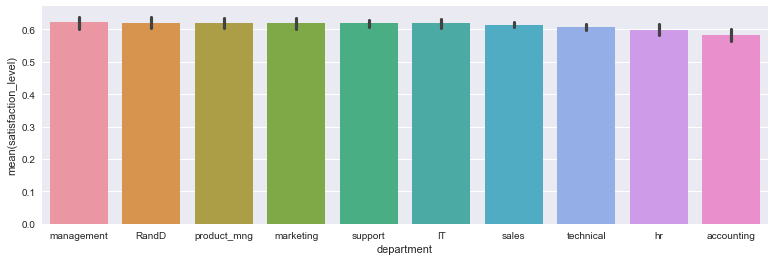

In [558]:
#How Satisfied is Each Department?
fig, axs = plt.subplots(figsize=(13, 4))

bar_plot = sns.barplot(x=hr_data.department, y=hr_data.satisfaction_level, 
                       order=get_ordered_group_index(hr_data, 'department', 'satisfaction_level'))

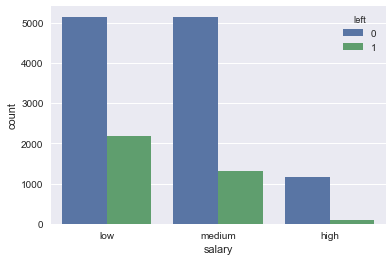

In [559]:
g=sns.countplot(x='salary', hue='left', data=hr_data) #shows the number of observations in 
#each categorical bin using bars; here: the dependecy of staying from the catagories of salary 

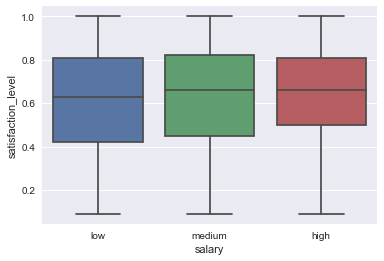

In [560]:
sns.boxplot(x='salary', y='satisfaction_level', data=hr_data); #satisfaction level referring to salary;
#again <;> is hiding the internal and irrelevant processing step

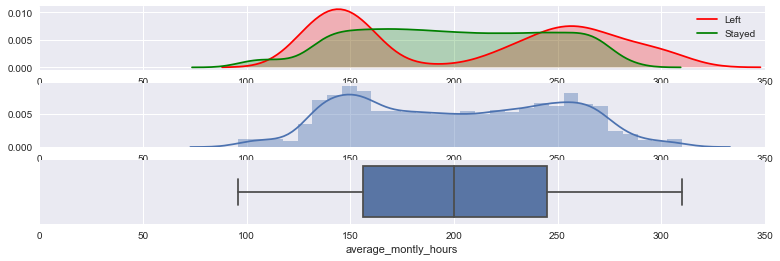

In [561]:
fig, axs = plt.subplots(nrows=3, figsize=(13, 4))

sns.kdeplot(employees_left.average_montly_hours, ax=axs[0], shade=True, color="r") #tool in seaborn for 
#examining univariate and bivariate distributions
kde_plot = sns.kdeplot(employees_stayed.average_montly_hours, ax=axs[0], shade=True, color="g")
kde_plot.legend(labels=['Left', 'Stayed'])

hist_plot = sns.distplot(hr_data.average_montly_hours, ax=axs[1])#plot a univariate distribution
box_plot = sns.boxplot(hr_data.average_montly_hours, ax=axs[2]) #Draw a box plot to show distributions

kde_plot.set(xlim=(0,350)) #set or query x-axis limits
hist_plot.set(xlim=(0,350))
box_plot.set(xlim=(0,350));

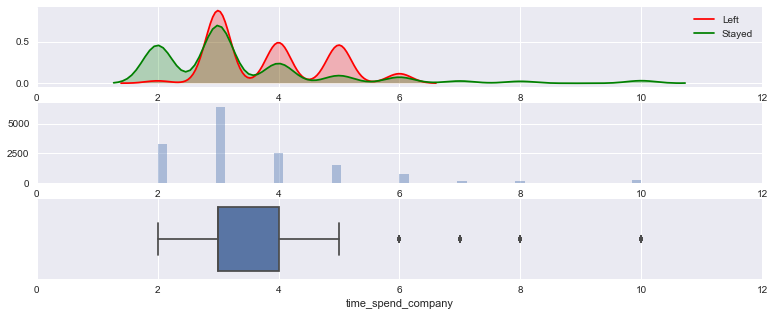

In [562]:
#Number of Years Working for the Company
fig, axs = plt.subplots(nrows= 3, figsize=(13, 5))

sns.kdeplot(employees_left.time_spend_company, ax=axs[0], shade=True, color="r")
kde_plot = sns.kdeplot(employees_stayed.time_spend_company, ax=axs[0], shade=True, color="g")
kde_plot.legend(labels=['Left', 'Stayed'])

hist_plot = sns.distplot(hr_data.time_spend_company, ax=axs[1], kde=False)
box_plot = sns.boxplot(hr_data.time_spend_company, ax=axs[2])

kde_plot.set(xlim=(0,12))
hist_plot.set(xlim=(0,12))
box_plot.set(xlim=(0,12));

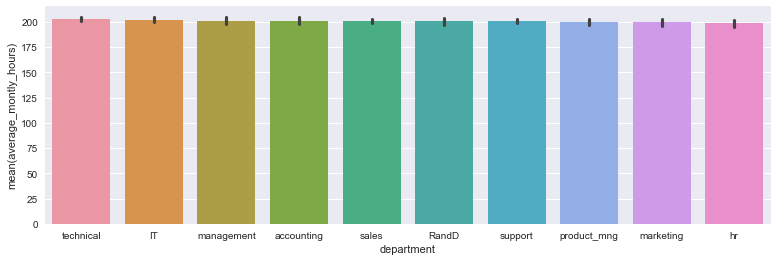

In [563]:
#How Hard does Each Department Work?
fig, axs = plt.subplots(figsize=(13, 4))

bar_plot = sns.barplot(x=hr_data.department, y=hr_data.average_montly_hours, 
                       order=get_ordered_group_index(hr_data, 'department', 'average_montly_hours') )

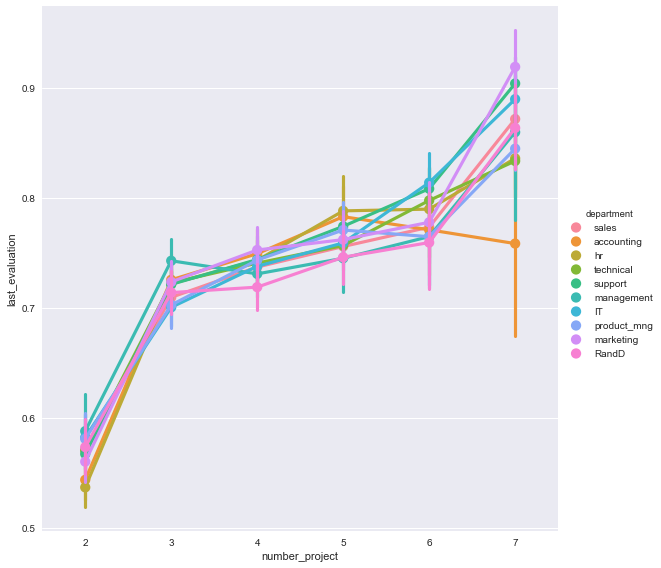

In [564]:
g=sns.factorplot(x='number_project', y='last_evaluation', hue='department', data=hr_data,size=8, aspect=1) 
#multiple graphs on the same plot in seaborn with factorplot, hue==colors in the legend, size(extension 
#of x-axis) and aspect ratio for better distinction (extension of y-axis)
#more information about the plot can be found: http://seaborn.pydata.org/generated/seaborn.factorplot.html

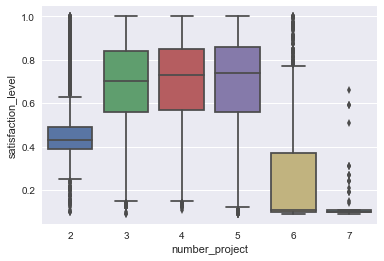

In [565]:
#showing the satisfaction level against the completed number of projects 
sns.boxplot(x='number_project', y='satisfaction_level', data=hr_data_new);
#again <;> is hiding the internal and irrelevant processing step
#more information about the boxplot can be found in the seaborn-documentation:
#https://seaborn.pydata.org/generated/seaborn.boxplot.html

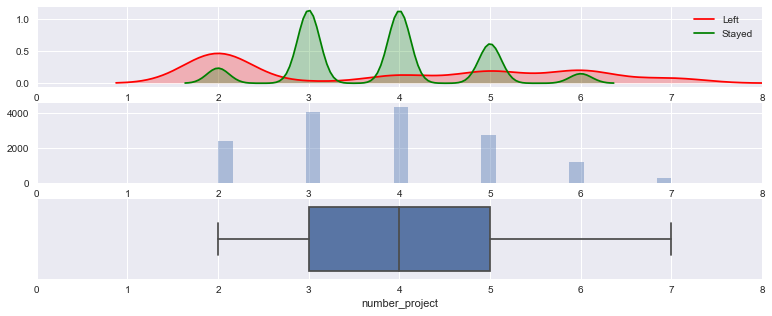

In [566]:
fig, axs = plt.subplots(nrows= 3, figsize=(13, 5))

sns.kdeplot(employees_left.number_project, ax=axs[0], shade=True, color="r")
kde_plot = sns.kdeplot(employees_stayed.number_project, ax=axs[0], shade=True, color="g")
kde_plot.legend(labels=['Left', 'Stayed'])

hist_plot = sns.distplot(hr_data.number_project, ax=axs[1], kde=False)
box_plot = sns.boxplot(hr_data.number_project, ax=axs[2])

kde_plot.set(xlim=(0,8))
hist_plot.set(xlim=(0,8))
box_plot.set(xlim=(0,8));

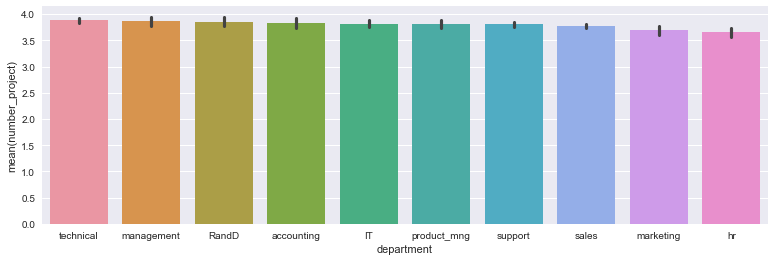

In [567]:
#How Many Projects are Assigned on Average per Employee?
fig, axs = plt.subplots(figsize=(13, 4))

bar_plot = sns.barplot(x=hr_data.department, y=hr_data.number_project, 
                       order=get_ordered_group_index(hr_data,'department', 'number_project'))

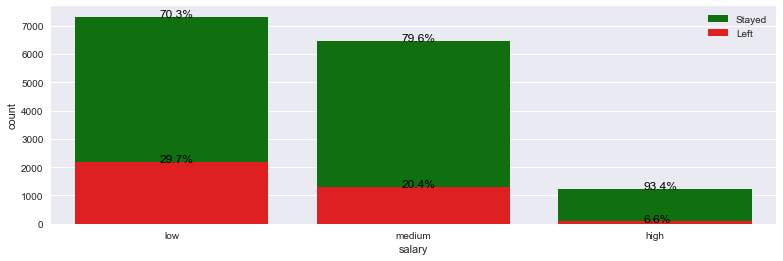

In [568]:
#General Overview about salaries
fig, axs = plt.subplots(figsize=(13, 4))

axe_name_order = hr_data.salary.value_counts().index

salary_plt = sns.countplot(hr_data.salary, order = axe_name_order, color='g');
sns.countplot(employees_left.salary, order = axe_name_order, color='r');

salary_plt.legend(labels=['Stayed', 'Left'])

#Annotate the percentages of those who stayed. It was more straightforward to loop for each 
#category (left, stayed) than doing all the work in one loop. The zip creates an output that 
#is equal to the shortest parameter, so we do not need to adjust the patches length, since
#the loop will stop after finishing the columns of those who stayed
for p, current_column in zip(salary_plt.patches, axe_name_order):
    current_column_total = hr_data[hr_data['salary'] == current_column].salary.count()
    stayed_count = p.get_height() - employees_left[employees_left['salary'] == current_column].salary.count()
    salary_plt.annotate(str(round( (100.0* stayed_count) /current_column_total, 1) )+ "%", 
                                (p.get_x() + 0.35, p.get_height()-10),
                                color='black', fontsize=12)
    
#In this loop, we want to use the patches located on the second half of patches list, which are the 
#bars for those who left.
for p, current_column in zip(salary_plt.patches[int(len(salary_plt.patches)/2):], axe_name_order):
    current_column_total = hr_data[hr_data['salary'] == current_column].salary.count()
    left_count = p.get_height()
    salary_plt.annotate(str(round( (100.0* left_count) /current_column_total, 1) )+ "%", 
                                (p.get_x() + 0.35, p.get_height()-10),
                                color='black', fontsize=12)

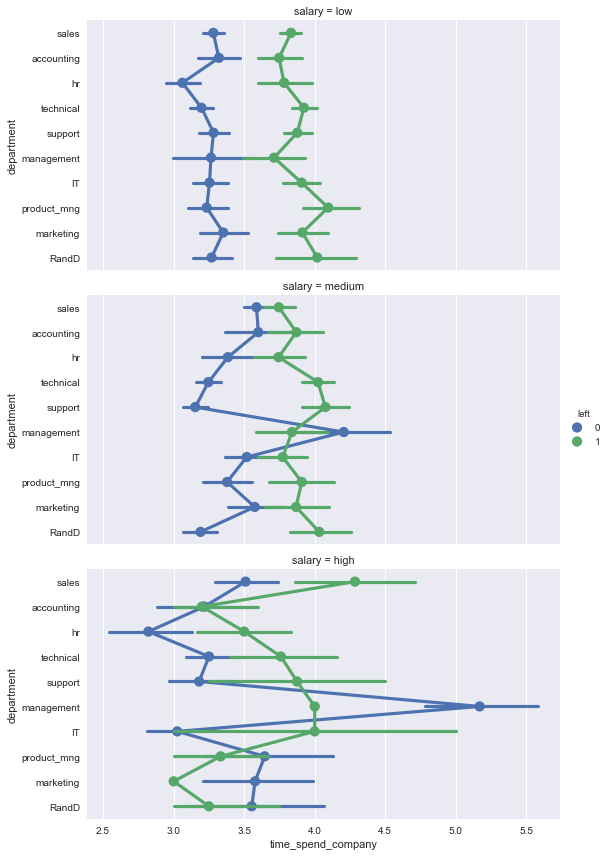

In [569]:
timeplot = sns.factorplot(x='time_spend_company', hue='left', y='department', row='salary', 
                          data=hr_data, aspect=2)
#the factorplot draws a categorical plot onto a FacetGrid; It is possible to make rather complex 
#plots using this function more information about parameters and using factorplots can be found in 
#documntation: https://seaborn.pydata.org/generated/seaborn.factorplot.html

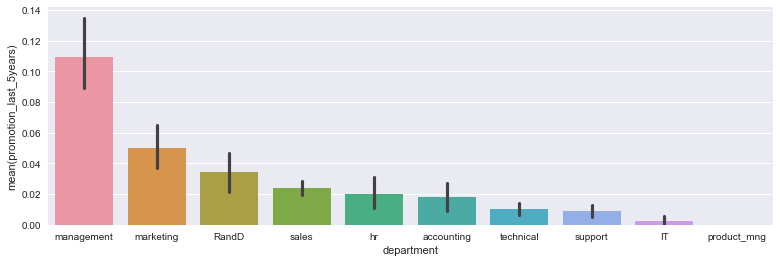

In [570]:
#Where are the Promotions?
fig, axs = plt.subplots(figsize=(13, 4))

bar_plot = sns.barplot(x=hr_data.department, y=hr_data.promotion_last_5years, 
                       order=get_ordered_group_index(hr_data, 'department', 'promotion_last_5years'))

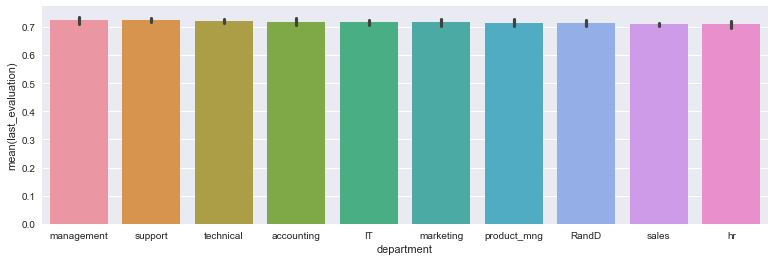

In [571]:
#Evaluation: Is the Management Department Really Outperforming the Rest?
fig, axs = plt.subplots(figsize=(13, 4))

bar_plot = sns.barplot(x=hr_data.department, y=hr_data.last_evaluation, 
                       order=get_ordered_group_index(hr_data,'department', 'last_evaluation'))

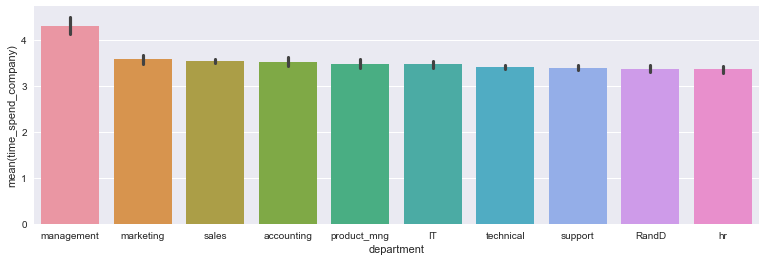

In [572]:
#Maybe they Stayed Longer?

fig, axs = plt.subplots(figsize=(13, 4))

bar_plot = sns.barplot(x=hr_data.department, y=hr_data.time_spend_company, 
                       order=get_ordered_group_index(hr_data, 'department', 'time_spend_company'))


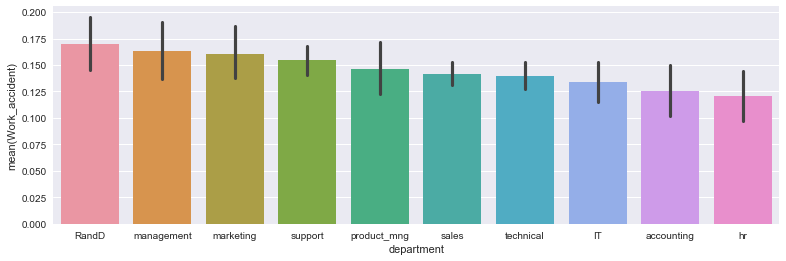

In [573]:
#Work Related Accidents
fig, axs = plt.subplots(figsize=(13, 4))

bar_plot = sns.barplot(x=hr_data.department, y=hr_data.Work_accident, 
                       order=get_ordered_group_index(hr_data, 'department', 'Work_accident'))

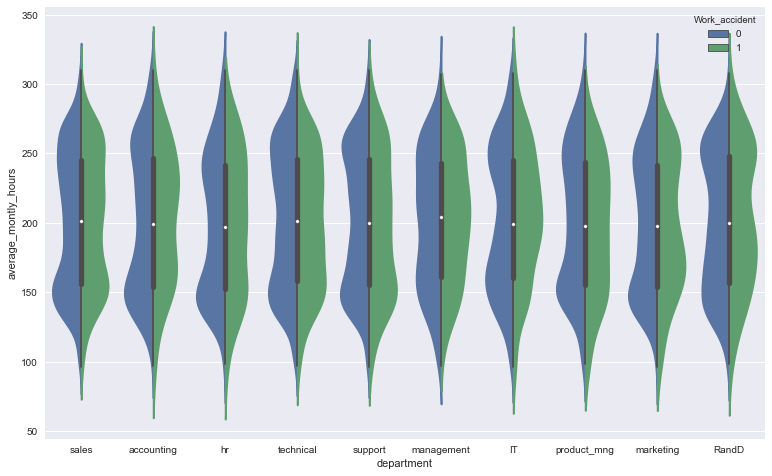

In [574]:
accidentplot = plt.figure(figsize=(10,6)) #advanced plotting with figure module for subplotting; 
#figsize-->w,h tuple in inches constructs the plotting area
#more information about the figure module can be found at: https://matplotlib.org/api/figure_api.html
accidentplotax = accidentplot.add_axes([0,0,1,1]) #Add an axes at position[left, bottom, width, height] 
#where all quantities are in fractions of figure width and height.
accidentplotax = sns.violinplot(x='department', y='average_montly_hours', 
                                hue='Work_accident', split=True, data = hr_data, jitter = 0.47)
#A violin plot plays a similar role as a box and whisker plot. It shows the distribution of 
#quantitative data across several levels of one (or more) categorical variables such that those 
#distributions can be compared. 
#more information about parameters and using violinplots can be found in documntation:
#https://seaborn.pydata.org/generated/seaborn.violinplot.html

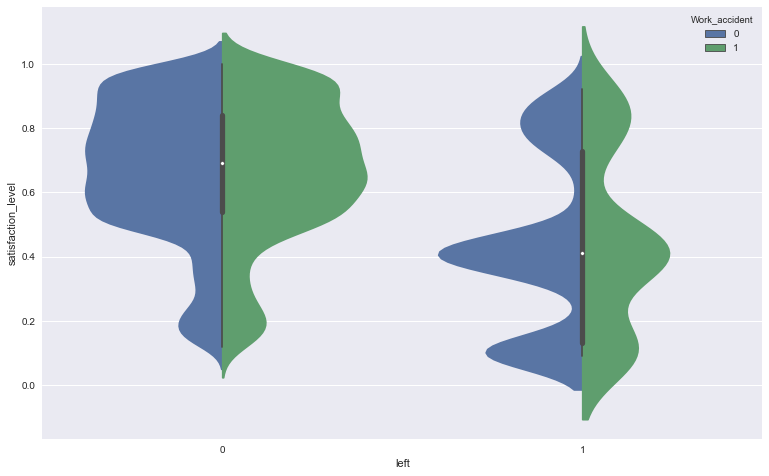

In [575]:
satisaccident = plt.figure(figsize=(10,6)) #we set the overall size of the diagram to 10x6 inches
satisaccidentax = satisaccident.add_axes([0,0,1,1]) #We scale the plot to the axes 

satisaccidentax = sns.violinplot(x='left', hue='Work_accident', y='satisfaction_level', 
                                 split=True, data=hr_data)
#We plot the entries in work accident with different colors (hue) and show the two different values in 
#one plot for the same argument. 

In [576]:
#A function to bin the average monthly hours into the categories described above
def work_load_cat(avg_mnthly_hrs):
    work_load = "unknown"
    if avg_mnthly_hrs < 168:
        work_load = "low"
    elif (avg_mnthly_hrs >= 168) & (avg_mnthly_hrs < 210):
        work_load = "average"
    elif (avg_mnthly_hrs >= 210) & (avg_mnthly_hrs < 252):
        work_load = "above_average"
    elif avg_mnthly_hrs >= 252:
        work_load = "workoholic"
        
    return work_load

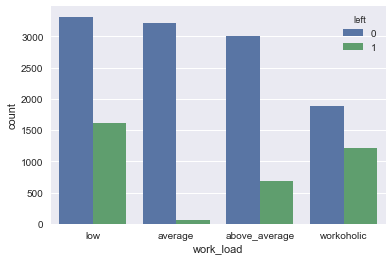

In [ ]:
hr_data['work_load'] = hr_data.average_montly_hours.apply(work_load_cat)

sns.countplot(x='work_load', hue='left', data=hr_data, order = ['low', 'average', 'above_average', 'workoholic']);

In [ ]:
#Normalised stacked
departments = list(set(hr_data.department.values))
number_of_departments = len(departments)

fig, axs = plt.subplots(nrows= int(number_of_departments/2), ncols=2, figsize=(13, 20))

for i in range(number_of_departments):
    current_dep = departments[i]
    
    ratio_df = 100*hr_data[hr_data.department == current_dep].groupby(['work_load', 'left']).agg({'work_load': 'count'})/hr_data[hr_data.department == current_dep].groupby(['work_load']).agg({'work_load': 'count'})
    ratio_df = ratio_df.reindex_axis(["low", "average", "above_average", "workoholic"], axis=0, level=0)
    #plot the department
    ratio_df.unstack().plot(kind='area',stacked=True, colormap= 'Spectral', ax=axs[int(i/2),i%2])
    axs[int(i/2),i%2].set_title(current_dep)
    axs[int(i/2),i%2].set_xlabel("")
    
axs[int(i/2),i%2].set_xlabel("work_load")
plt.subplots_adjust(hspace=0.3);

In [ ]:
#Understanding how the Company Evaluates its Employees
#A function to bin last evaluation into one of 5 categories
def last_evaluation_cat(last_evaluation):
    evaluation = "unknown"
    if last_evaluation < 0.45:
        evaluation = "very_low"
    elif (last_evaluation >= 0.45) & (last_evaluation < 0.55):
        evaluation = "mediocre"
    elif (last_evaluation >= 0.55) & (last_evaluation < 0.8):
        evaluation = "average"
    elif (last_evaluation >= 0.8) & (last_evaluation < 0.9):
        evaluation = "very_good"
    elif last_evaluation >= 0.9:
        evaluation = "excellent"
        
    return evaluation

In [ ]:
hr_data['evaluation'] = hr_data.last_evaluation.apply(last_evaluation_cat)

In [ ]:
sns.countplot(x='evaluation',  data=hr_data, order = ["unknown", 'very_low', 'mediocre', 
                                                      'average', 'very_good', 'excellent']);

In [ ]:
sns.countplot(x='evaluation',  hue = 'left', data=hr_data, 
              order = ["unknown", 'very_low', 'mediocre', 'average', 'very_good', 'excellent']);

In [ ]:
evaluation_index_order = ["unknown", 'very_low', 'mediocre', 'average', 'very_good', 'excellent']
evaluation_xticks = ['Very Low\n (eval < .45)', 'Mediocre\n ( .45 < eval < .55 )', 
                     'Average\n ( .55 < eval < .8 )', 'Very Good\n ( .8 < eval < .9 )', 'Excellent\n ( .9 < eval)']
evaluation_x_label = "Company Evaluation for the Employee"

In [ ]:
#A function to bin the average monthly hours into the categories described above
def work_load_cat(avg_mnthly_hrs):
    work_load = "unknown"
    if avg_mnthly_hrs < 168:
        work_load = "low"
    elif (avg_mnthly_hrs >= 168) & (avg_mnthly_hrs < 210):
        work_load = "average"
    elif (avg_mnthly_hrs >= 210) & (avg_mnthly_hrs < 252):
        work_load = "above_average"
    elif avg_mnthly_hrs >= 252:
        work_load = "workoholic"
        
    return work_load

In [ ]:
#Performance Categories Makeup in Terms of Working Hours
employees_by_eval_and_workload = group_by_2_level_perc(hr_data, 
                                                       'evaluation', 'work_load',
                                                       evaluation_index_order, 
                                                       ['low','average','above_average', 'workoholic'])#Index Order

workload_legend = ['Low Workload (< 40hrs/week)', 'Average Workload (40 < wl < 50 hrs/week)',
                   'Above Average Workload (50 < wl < 60hrs/week)', 
                   'Workoholic Workload (wl > 60hrs/week)']

#Plot the Graph
p=employees_by_eval_and_workload.unstack().plot(kind='area',stacked=True, colormap= 'Spectral', 
                                                figsize=(15, 6), zorder=0)

customise_2lvl_perc_area_graph(p, workload_legend, 
                               xtick_label=evaluation_xticks, x_label=evaluation_x_label, 
                               y_label="Percentage of Monthly Workload")

In [ ]:
#Number of Years with the Company
employees_by_eval_and_time_in_company_perc = group_by_2_level_perc(hr_data, 
                                                                   'evaluation', 
                                                                   'time_spend_company',
                                                                   evaluation_index_order)

#Plot the Graph
p=employees_by_eval_and_time_in_company_perc.unstack().plot(kind='area',
                                                            stacked=True, 
                                                            colormap= 'Spectral', 
                                                            figsize=(15, 6), zorder=0)

time_spent_legend = [str(x) + " years" for x in range(2,9)] + ['10 years']

customise_2lvl_perc_area_graph(p, time_spent_legend, xtick_label=evaluation_xticks, 
                               x_label=evaluation_x_label, #Company Evaluation Graph
                               y_label="Percentage of Years in Company")


In [ ]:
#Number of Projects
employees_by_eval_and_time_in_company_perc = group_by_2_level_perc(hr_data, 
                                                                   'evaluation', 'number_project',
                                                                   evaluation_index_order)

#Plot the Graph
p=employees_by_eval_and_time_in_company_perc.unstack().plot(kind='area',stacked=True, colormap= 'Spectral', figsize=(15, 6), zorder=0)

num_projects_legend = [str(x) + " projects" for x in range(2,8)]

customise_2lvl_perc_area_graph(p, num_projects_legend, 
                               xtick_label=evaluation_xticks, x_label=evaluation_x_label, 
                               y_label="Percentage of Number of Projects Assigned")

In [ ]:
#salary
employees_by_eval_and_salary_perc = group_by_2_level_perc(hr_data, 
                                                          'evaluation', 'salary', 
                                                          evaluation_index_order, 
                                                          ['low', 'medium', 'high'])

#Plot the Graph
p=employees_by_eval_and_salary_perc.unstack().plot(kind='area',stacked=True, colormap= 'Spectral', 
                                                   figsize=(15, 6), zorder=0)

num_projects_legend = ['Low', 'Medium', 'High']

customise_2lvl_perc_area_graph(p, num_projects_legend, 
                               xtick_label=evaluation_xticks, x_label=evaluation_x_label, 
                               y_label="Percentage of Salary Range")

In [ ]:
#satisfaction level
#Create a satisfaction categories
#Arbitrary boundaries:
# < 4.5 low
# 4.5 < < 7.5 medium
# 7.5 < high
def rank_satisfaction(employee):
    level = "unknown"
    if employee.satisfaction_level < 0.45:
        level='low'
    elif employee.satisfaction_level < 0.75:
        level = 'medium'
    else:
        level = 'high'
    return level

In [ ]:
hr_data['satisfaction'] = hr_data.apply(rank_satisfaction, axis=1)

In [ ]:
employees_by_eval_and_satisfaction_perc = group_by_2_level_perc(hr_data, 
                                                                'evaluation', 
                                                                'satisfaction', 
                                                                evaluation_index_order, 
                                                                ['low', 'medium', 'high'])

#Plot the Graph
p=employees_by_eval_and_satisfaction_perc.unstack().plot(kind='area',stacked=True, 
                                                         colormap= 'Spectral', figsize=(15, 6), 
                                                         zorder=0)


satisfaction_lvl_legend = ['Low', 'Medium', 'High']

customise_2lvl_perc_area_graph(p, satisfaction_lvl_legend, 
                               xtick_label=evaluation_xticks, x_label=evaluation_x_label, 
                               y_label="Percentage of Employee's Satisfaction Level")

In [ ]:
import sys
print(sys.version)